In [51]:
import numpy as np
from numpy import sin,cos,exp,tan,log,log10

import scipy as s
from scipy.integrate import odeint
from scipy import pi

import matplotlib.pyplot as plt
import time


seed = 3  # parameter to create file name (it starts with this integer number)

# relevant values of seed:
# 1 - initial few investigations
# 2 - H = -0.9*H, vary initial angle

In [87]:
# physical parameters

reduce_g = 0.2 # reduce g in order to see radial oscillations in a shorter tube with shorter time !!!
g = reduce_g * 9.81   # gravity acceleration (N/kg)

a = 0.05   # radius of tube (m)
H = 0.5  # length of tube (m)
h = 0.01   # thickness of tube (m)
sigma = 5.92e7   # conductivity of tube material (Siemens)
mu = 4*pi*1e-7   # magnetic permeability
m = 2   # dipole moment (A/m^2)
M = 0.0030   # mass of magnet (kg)
I = 1e-9   # moment of intertia of magnet (kg*m^2)



# simulation parameters
t_max = 2
max_iter = 20000   # total number of iterations in time
dt = t_max/max_iter

init_height = -0.3*H # setting the initial condition z[0]
init_displ = 0*a  # setting the initial condition x[0]
init_angle = 0.1

N = 100  # number of ring partitions of tube
dH = H/N   # height of one ring
R = 2*pi*a/(sigma*h*dH)   # resistance of one ring (Ohm)
Z_ring = -(np.arange(N)+1/2) * dH   # array that stores effective positions of rings (midpoints in z)
#print(Z_ring)


#def Bx(x,z,alpha,phi):
#    """This function calculates the x-component of magnetic field from a magnet at [x,0,z] tilted at angle alpha
#    at a line element with azimuthal angle phi, of a ring in x-y plane """ 
#    Bx = m * (3*z * cos(alpha) * (x - a*cos(phi))   +   1/2 * (a**2 + 4*x**2 - 2*z**2 - 8*a*x*cos(phi) + 
#      3*a**2*cos(2*phi)) * sin(alpha) )      /      (a**2 + x**2 + z**2 - 2 *a *x *cos(phi)) ** (5/2)
#    return Bx

#def By(x,z, alpha, phi)
#    """This function calculates the y-component of magnetic field from a magnet at [x,0,z] tilted at angle alpha
#    at a line element with azimuthal angle phi, of a ring in x-y plane """ 
#    By = -3 * a * m * (z*cos(alpha) + (x - a*cos(phi) * sin(alpha)) * sin(phi)    /      (a**2 + x**2 + z**2 - 2 *a *x *cos(phi)) ** (5/2)
#    return By

def emf(x,z,vz, alpha):
    """This function calculates the e.m.f. by doing integral "v cross B" along the body of the ring, neglecting the vx component
    of motion, which is much smaller than vz component."""
    def Bx_dipmag(phi):
        return m * (3*z * cos(alpha) * (x - a*cos(phi))   +   1/2 * (a**2 + 4*x**2 - 2*z**2 - 8*a*x*cos(phi) + 
        3*a**2*cos(2*phi)) * sin(alpha) )      /      (a**2 + x**2 + z**2 - 2 *a *x *cos(phi)) ** (5/2)
    def By_dipmag(phi):
        return -3 * a * m * (z*cos(alpha) + (x - a*cos(phi) * sin(alpha))) * sin(phi) / (a**2 + x**2 + z**2 - 2 *a *x *cos(phi)) ** (5/2)
    integral =  s.integrate.quad(lambda phi: By_dipmag(phi)*sin(phi) + Bx_dipmag(phi)*cos(phi), 0, 2*pi )
    integral = integral[0]
    integral *=  mu/4/pi * vz * a
    return integral


def force_z(x,z,alpha,J):
    """Magnetic force of an elemental ring in z-direction, argument z interpreted as z(magnet) - z_ring"""
    u = x/a
    v = z/a
    integral_z = s.integrate.quad(lambda phi: v * (1 - u*cos(phi)) / (1 + u**2 + v**2 - 2*u*cos(phi))**(5/2), 0, 2*pi)
    integral_z = integral_z[0]
    integral_z *= + 3 * mu/4/pi * m * cos(alpha) / a**2 * J
    integral_x = s.integrate.quad(lambda phi: (-3*u + (2+2*u**2-v**2)*cos(phi) - u*cos(phi)**2) / (1 + u**2 + v**2 - 2*u*cos(phi))**(5/2), 0, 2*pi)
    integral_x = integral_x[0]
    integral_x *= +  mu/4/pi * m * sin(alpha) / a**2 * J
    return integral_x + integral_z
    
def force_x(x,z,alpha,J):
    """Magnetic force of an elemental ring in x-direction, argument z interpreted as z(magnet) - z_ring"""
    u = x/a
    v = z/a
    integral_z = s.integrate.quad(lambda phi: cos(phi) * (1 + u**2  - 2*v**2 - 2*u*cos(phi)) / (1 + u**2  + v**2 - 2*u*cos(phi))**(5/2), 0, 2*pi)
    integral_z = integral_z[0]
    integral_z *= +  mu/4/pi * m*cos(alpha) / a**2 * J
    integral_x = s.integrate.quad(lambda phi: cos(phi) * (u - cos(phi))/ (1 + u**2  + v**2 - 2*u*cos(phi))**(5/2), 0, 2*pi)
    integral_x = integral_x[0]
    integral_x *= - 3 * v *  mu/4/pi * m*sin(alpha) / a**2 * J
    return integral_x + integral_z



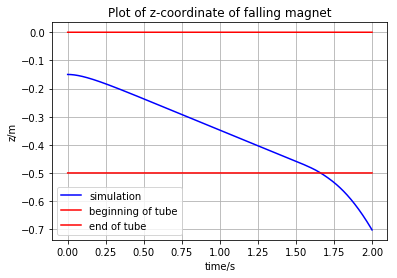

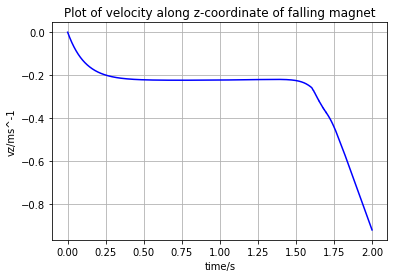

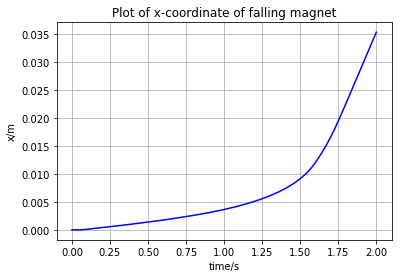

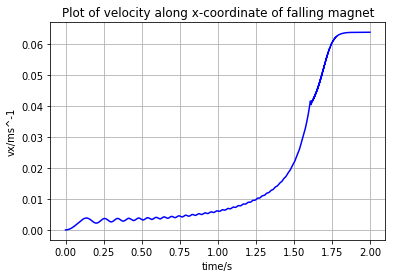

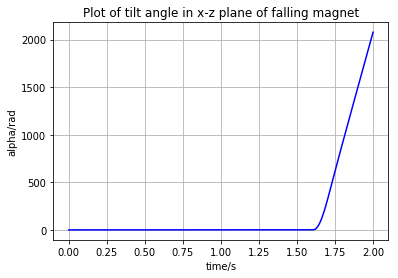

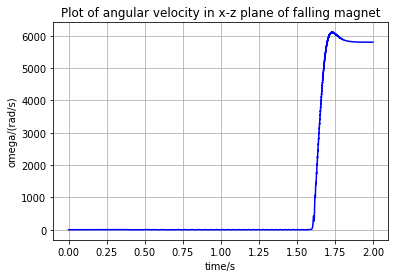

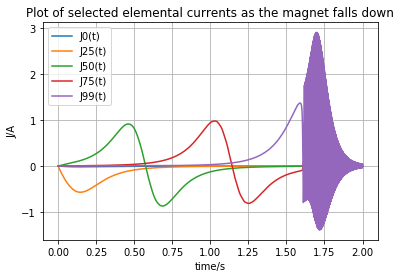

final coordinate of magnet, in cm: -70.24
and in case of free fall, in cm:   -407.40


simulation took 4413.00 s


In [88]:
# initiate arrays that store our data

T = np.linspace(0,t_max,max_iter)   # array that stores all points in time 

z = np.zeros((max_iter))   # array that stores coordinates of magnet along axes as time progresses
vz = np.zeros((max_iter))
az = np.zeros((max_iter))

x = np.zeros((max_iter))   # array that stores radial coordinates of magnet in x-z plane as time progresses
vx = np.zeros((max_iter))
ax = np.zeros((max_iter))

alpha = np.zeros((max_iter))   # array that stores the tilt of magnet in x-z plane as time progresses
d1_alpha = np.zeros((max_iter))
d2_alpha = np.zeros((max_iter))

J = np.zeros((max_iter, N))  # array that stores currents (in Amperes) in all rings as time progresses
Fx = np.zeros((max_iter, N)) # array that stores lateral forces (in Newtons) from each ring as time progresses
Fz = np.zeros((max_iter, N)) # array that stores vertical forces (in Newtons) from each ring as time progresses
Gy = np.zeros((max_iter, N)) # array that stores torques (in Newtons*metres) from each ring as time progresses



# now implement ICs to get values for first two iterations

z[0] = init_height
az[0] = -g
vz[0] = 1/2*dt*az[0] # vz[0] is in fact vz[1/2], all indices for velocity are shifted forwards by 1/2
z[1] = z[0] + vz[0]*dt

x[0] = init_displ
ax[0] = 0
vx[0] = 1/2*dt*ax[0] # vx[0] is in fact vx[1/2], all indices for velocity are shifted forwards by 1/2
x[1] = x[0] + vx[0]*dt

alpha[0] = init_angle
d2_alpha[0] = 0
d1_alpha[0] = 1/2*dt*d2_alpha[0] # d1_alpha[0] is in fact d1_alpha[1/2], all indices for angularvelocity are shifted forwards by 1/2
alpha[1] = alpha[0] + d1_alpha[0]*dt

J[0,:] = 0
for n in range(N):
    J[1,n] = 1/R * emf(x[1],z[1]-Z_ring[n],vz[0]+1/2*dt*az[0],alpha[1])  # use extrapolated velocity between V[1/2] and V[3/2] to approximate V[1]



# solve using an improved finite difference approach "x[t+dt] = x[t] + dt*x'[t+1/2*dt]"

sim_start = time.time()

for i in range(1,max_iter-1):
        
    for n in range(N):  # quite stupid way, should later vectorize, but probably would not make much difference,
                        # as looping is likely negligible compared to all these horrible numerical integrations
        Fx[i,n] = force_x(x[i], z[i]-Z_ring[n], alpha[i], J[i,n])
        Fz[i,n] = force_z(x[i], z[i]-Z_ring[n], alpha[i], J[i,n])
        Gy[i,n] = - (m*sin(alpha[i])) * mu*J[i,n]*a**2 / 2 /(a**2 + (z[i]-Z_ring[n])**2)**(3/2)  # Gy = mz*Bx - mx*Bz = - mx*Bz (2nd = only on axis)
        
    ax[i] = 1/M * sum(Fx[i,:])   # sum all forces corresponding to separate rings at iteration i
    az[i] = -g + 1/M * sum(Fz[i,:])
    d2_alpha[i] = 1/I * sum(Gy[i,:])
    
    vx[i] = vx[i-1] + ax[i]*dt   # e.g. for i=1: V[3/2] = V[1/2] + A[1]*dt
    vz[i] = vz[i-1] + az[i]*dt   # e.g. for i=1: V[3/2] = V[1/2] + A[1]*dt
    d1_alpha[i] = d1_alpha[i-1] + d2_alpha[i]*dt
    
    x[i+1] = x[i] + vx[i]*dt   # e.g. for i=1: Z[2] = Z[1] + V[3/2]*dt
    z[i+1] = z[i] + vz[i]*dt   # e.g. for i=1: Z[2] = Z[1] + V[3/2]*dt
    alpha[i+1] = alpha[i] + d1_alpha[i]*dt
    
    for n in range(N):
        J[i+1,n] = 1/R * emf(x[i+1], z[i+1]-Z_ring[n],vz[i]+1/2*dt*az[i], alpha[i+1]) # e.g. for i=1: J[2] = f( Z[2], V[3/2]+A[2]*1/2*dt )

sim_end = time.time()


    
plt.plot(T,z,'b',label='simulation')
#plt.plot(T,init_height-1/2*g*T**2,'g',label='free fall')
plt.plot(T, 0*np.ones(max_iter),'r', label='beginning of tube')
plt.plot(T, -H*np.ones(max_iter),'r', label='end of tube')
plt.legend()
plt.xlabel('time/s')
plt.ylabel('z/m')
plt.title('Plot of z-coordinate of falling magnet')
plt.grid()
plt.show()

plt.plot(T[:-1],vz[:-1],'b')
plt.xlabel('time/s')
plt.ylabel('vz/ms^-1')
plt.title('Plot of velocity along z-coordinate of falling magnet')
plt.grid()
plt.show()

plt.plot(T,x,'b',label='simulation')
plt.xlabel('time/s')
plt.ylabel('x/m')
plt.title('Plot of x-coordinate of falling magnet')
plt.grid()
plt.show()

plt.plot(T[:-1],vx[:-1],'b')
plt.xlabel('time/s')
plt.ylabel('vx/ms^-1')
plt.title('Plot of velocity along x-coordinate of falling magnet')
plt.grid()
plt.show()

plt.plot(T,alpha,'b',label='simulation')
plt.xlabel('time/s')
plt.ylabel('alpha/rad')
plt.title('Plot of tilt angle in x-z plane of falling magnet')
plt.grid()
plt.show()

plt.plot(T[:-1],d1_alpha[:-1],'b')
plt.xlabel('time/s')
plt.ylabel('omega/(rad/s)')
plt.title('Plot of angular velocity in x-z plane of falling magnet')
plt.grid()
plt.show()

for k in [0, N//4, N//2, 3*N//4, N-1]:
    plt.plot(T, J[:,k], label='J'+str(k)+'(t)')
plt.xlabel('time/s')
plt.ylabel('J/A')
plt.legend()
plt.title('Plot of selected elemental currents as the magnet falls down')
plt.grid()
plt.show()
    

#def saveArrays(folder, seed, variable, N, max_iter, t_max, alpha):
#    np.savetxt('{}/{}_'+str(variable)'_N{}_iter{}_t{}_alpha{}'.format(folder, seed, N, max_iter, t_max), x)


#folder = 'python_arrays_nonparallel_onaxis'

#for variable in [x,vx,z,vz,J]:
#    np.savetxt(getName[variable].format(folder, seed, N, max_iter, t_max), variable)

np.savetxt('{}/{}_x_N{}_iter{}_t{}_angle{}'.format(folder, seed, N, max_iter, t_max, init_angle), x)
np.savetxt('{}/{}_vx_N{}_iter{}_t{}_angle{}'.format(folder, seed, N, max_iter, t_max, init_angle), vx)
np.savetxt('{}/{}_z_N{}_iter{}_t{}_angle{}'.format(folder, seed, N, max_iter, t_max, init_angle), z)
np.savetxt('{}/{}_vz_N{}_iter{}_t{}_angle{}'.format(folder, seed, N, max_iter, t_max, init_angle), vz)
np.savetxt('{}/{}_J_N{}_iter{}_t{}_angle{}'.format(folder, seed, N, max_iter, t_max, init_angle), J)
np.savetxt('{}/{}_alpha_N{}_iter{}_t{}_angle{}'.format(folder, seed, N, max_iter, t_max, init_angle), alpha)

#ref = -65.1665
print("final coordinate of magnet, in cm:","{:.2f}".format(z[-1]*100))
#print("value from ref. simulation, in cm:", ref)
print("and in case of free fall, in cm:  ","{:.2f}".format((init_height-1/2*g*T[-1]**2)*100))
print()
#print("percentage error of reduction in free-fall distance from reference:  ",(z[-1]*100-ref)/((init_height-1/2*g*T[-1]**2)*100 - ref) * 100,"%")
print()
print("simulation took","{:.2f}".format(sim_end-sim_start),"s")


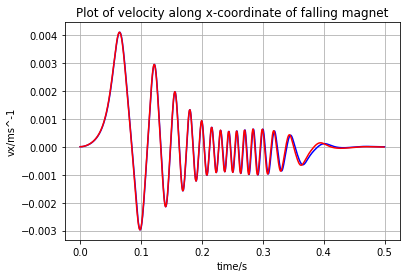

In [72]:
# this cell loads data for a W. Mathematica and Python simulation(s) 
# in order to plot trajectories and physical properties of falling magnet
# if comparing WM and Py one should check that physical and simulation parameters agree!!!

# modify simulation parameters in filename, the file containing array of datapoint for indicated variable
# with corresponding simulation is then loaded (if exists!)

# adapted to also compare two Python simulations together!
# simply manually overwrite the parameters that are needed
# common parameters in filename for both sim. 1 and 2 (one of them in fact not in common, see later):
folder, seed, N, max_iter, t_max, init_angle = 'python_arrays_nonparallel_onaxis', 2, 100, 5000, 0.5, 0.1

# change to relevant parameter of simulation 1:
max_iter = 5000
X_py1 = np.genfromtxt('{}/{}_x_N{}_iter{}_t{}_angle{}'.format(folder, seed, N, max_iter, t_max, init_angle))
Vx_py1 = np.genfromtxt('{}/{}_vx_N{}_iter{}_t{}_angle{}'.format(folder, seed, N, max_iter, t_max, init_angle))
Z_py1 = np.genfromtxt('{}/{}_z_N{}_iter{}_t{}_angle{}'.format(folder, seed, N, max_iter, t_max, init_angle))
Vz_py1 = np.genfromtxt('{}/{}_vz_N{}_iter{}_t{}_angle{}'.format(folder, seed, N, max_iter, t_max, init_angle))
alpha_py1 = np.genfromtxt('{}/{}_vz_N{}_iter{}_t{}_angle{}'.format(folder, seed, N, max_iter, t_max, init_angle))

# change to relevant parameter of simulation 2:
max_iter = 500
X_py2 = np.genfromtxt('{}/{}_x_N{}_iter{}_t{}_angle{}'.format(folder, seed, N, max_iter, t_max, init_angle))
Vx_py2 = np.genfromtxt('{}/{}_vx_N{}_iter{}_t{}_angle{}'.format(folder, seed, N, max_iter, t_max, init_angle))
Z_py2 = np.genfromtxt('{}/{}_z_N{}_iter{}_t{}_angle{}'.format(folder, seed, N, max_iter, t_max, init_angle))
Vz_py2 = np.genfromtxt('{}/{}_vz_N{}_iter{}_t{}_angle{}'.format(folder, seed, N, max_iter, t_max, init_angle))
alpha_py2 = 
# need to enter manually the length of both Python simulations
T1 = np.linspace(0,0.5,5000)
T2 = np.linspace(0,0.5,500)

# likewise for Mathematica files
#X_wm = np.genfromtxt("mathematica_arrays/sim1_U.dat")
#Z_wm = np.genfromtxt("mathematica_arrays/sim1_Z.dat")


"""
# here, we can plot the trajectory in space

plt.figure(figsize=(10,10))
plt.plot(X_py1, Z_py1, 'b', label='simulation in Python #1')
plt.plot(X_py2, Z_py2, 'g', label='simulation in Python #2')
#plt.plot(X_wm, Z_wm, 'y', label='simulation in Mathematica')  # only relevant for a choice of parameters
plt.plot([-a,+a], [-H,-H],'r--', label='tube wall')
plt.plot([-a,+a], [0,0],'r--')
plt.plot([-a,-a], [0, -H], 'r')
plt.plot([+a,+a], [0, -H], 'r')
plt.plot([0,0], [0, -H], 'k--')
plt.xlabel('x/m')
plt.ylabel('z/m')
plt.legend()
plt.title('Plot of spatial trajectory of falling magnet')
plt.grid()
plt.show()
"""

plt.plot(T1[:-1],Vx_py1[:-1],'b')
plt.plot(T2[:-1],Vx_py2[:-1],'r')
plt.xlabel('time/s')
plt.ylabel('vx/ms^-1')
plt.title('Plot of velocity along x-coordinate of falling magnet')
plt.grid()
plt.show()

plt.plot(T,alpha,'b',label='simulation')
plt.xlabel('time/s')
plt.ylabel('alpha/rad')
plt.title('Plot of tilt angle in x-z plane of falling magnet')
plt.grid()
plt.show()